In [1]:
import sys
sys.path.append('../')

In [2]:
# Enable autoreload for external modules
%load_ext autoreload
%autoreload 2

In [3]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from util import *

In [4]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [5]:
model_version = 'v16.4'
base_model_version = 'v16.0'

In [6]:
with open('../data_schema_V2.0.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [7]:
df = pd.read_csv(f"../data/processed/photometry_only.csv")

X = df[photo_cols + generic_cols]
y = df[target_col]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed_value)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
input_shape = X_train_scaled.shape[1]

optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(inputs)
x = layers.Dropout(0.2, name='Dropout_64')(x)

# Layer 2
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)

# Layer 3
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_256')(x)
x = layers.Dropout(0.2, name='Dropout_256')(x)

# Layer 4
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_128_2')(x)
x = layers.Dropout(0.2, name='Dropout_128_2')(x)

# Output layer
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Regression_Model')

model.load_weights(f"../models/{base_model_version}/spec_photo_model.h5", by_name=True, skip_mismatch=True)

model.get_layer('Dense_64').trainable = True
model.get_layer('Dense_128').trainable = True
model.get_layer('Dense_256').trainable = True
model.get_layer('Dense_128_2').trainable = True

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.mean_squared_error, 
              metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 10)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                704       
                                                                 
 Dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 Dense_256 (Dense)           (None, 256)               33024     
                                                                 
 Dropout_256 (Dropout)       (None, 256)          

In [11]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.5, verbose=1, callbacks=[early_stopping])

Epoch 1/200
2438/2438 [==============================] - 19s 8ms/step - loss: 0.0946 - mae: 0.1992 - mse: 0.0749 - mape: 1.9109 - val_loss: 0.0494 - val_mae: 0.1230 - val_mse: 0.0333 - val_mape: 1.1957
Epoch 2/200
2438/2438 [==============================] - 17s 7ms/step - loss: 0.0731 - mae: 0.1731 - mse: 0.0581 - mape: 1.6606 - val_loss: 0.0426 - val_mae: 0.0965 - val_mse: 0.0286 - val_mape: 0.9465
Epoch 3/200
2438/2438 [==============================] - 17s 7ms/step - loss: 0.0678 - mae: 0.1642 - mse: 0.0541 - mape: 1.5791 - val_loss: 0.0423 - val_mae: 0.0979 - val_mse: 0.0290 - val_mape: 0.9551
Epoch 4/200
2438/2438 [==============================] - 18s 7ms/step - loss: 0.0661 - mae: 0.1589 - mse: 0.0529 - mape: 1.5333 - val_loss: 0.0435 - val_mae: 0.0958 - val_mse: 0.0304 - val_mape: 0.9491
Epoch 5/200
2438/2438 [==============================] - 17s 7ms/step - loss: 0.0645 - mae: 0.1557 - mse: 0.0516 - mape: 1.5045 - val_loss: 0.0418 - val_mae: 0.0859 - val_mse: 0.0294 - val_map

In [12]:
model.save(f"../models/{model_version}/photo_only_model.h5")

In [13]:
save_history(history, model_version, history_name='history_photo_only')

In [14]:
y_pred = model.predict(X_test_scaled)

2090/2090 [==============================] - 3s 1ms/step


In [15]:
plot_metrics(y_test, y_pred)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.0846
Root Mean Squared Error (RMSE): 0.1735
R² Score: 0.9290


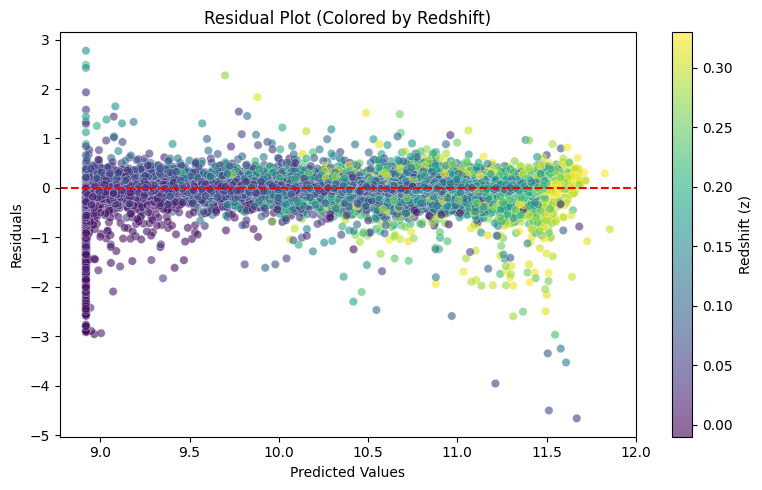

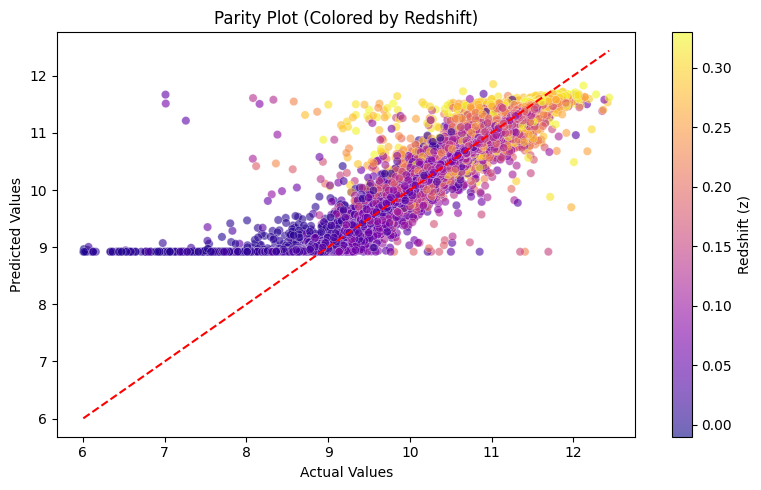

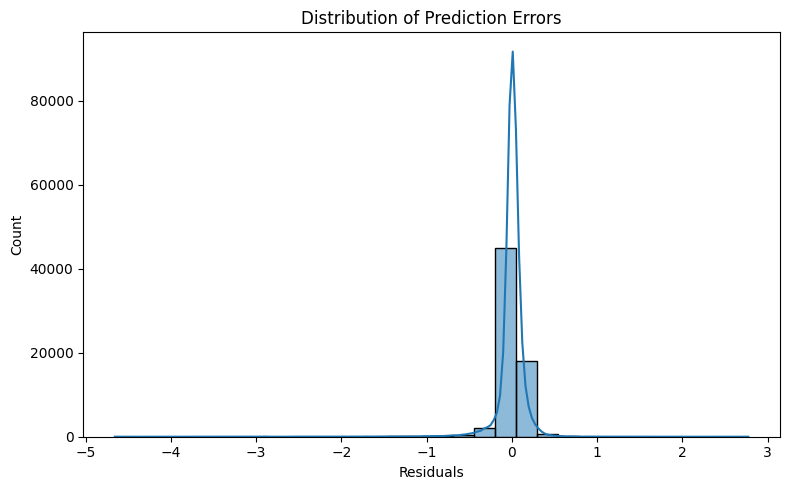

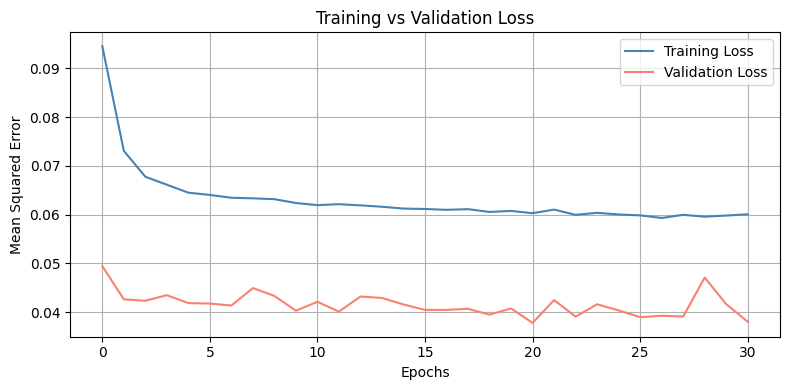

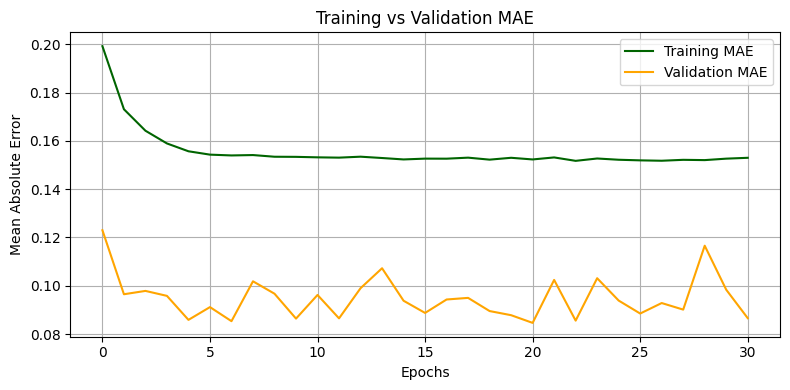

In [16]:
plot_visualizations(y_test, y_pred, z_values=X_test['z'], history=history)